In [1]:
import numpy as np
import gensim.downloader as api
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
import os
from gensim.models import KeyedVectors
from sklearn.metrics import mean_squared_error
from cuml.manifold import UMAP
import csv
import pandas as pd

In [2]:
class ReducedEmbeddingModel:
    def __init__(self, vectors, index_to_key):
        self.vectors = vectors
        self.index_to_key = index_to_key
        self.key_to_index = {word: idx for idx, word in enumerate(index_to_key)}
    
    def __getitem__(self, word):
        if word in self.key_to_index:
            return self.vectors[self.key_to_index[word]]
        raise KeyError(f"Word '{word}' not found in vocabulary")
    
    def __contains__(self, word):
        return word in self.key_to_index


def load_word2vec_model(file_path):
    """Loads Word2Vec embeddings from a binary file."""
    print("Loading Word2Vec model...")
    wv = KeyedVectors.load_word2vec_format(file_path, binary=True)
    vectors = wv.vectors
    index_to_key = wv.index_to_key
    return ReducedEmbeddingModel(vectors, index_to_key)        

def load_similarity_dataset(file_path):

  data = []
  with open(file_path, 'r') as file:
        next(file)  # Skip header
        for line in file:
            parts = line.strip().split('\t')
            word1, word2, similarity_score = parts[0], parts[1], float(parts[3])
            data.append((word1, word2, similarity_score))
  return data

# Cosine similarity function for similarity evaluation
def cosine_similarity(v1, v2):
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    if norm1 == 0 or norm2 == 0:
        return 0
    return np.dot(v1, v2) / (norm1 * norm2)

# Evaluate embeddings on the SimLex-999 data
def evaluate_embeddings(model, word_pairs):
    predicted_scores = []
    true_scores = []
    
    for word1, word2, true_score in word_pairs:
        if word1 in model and word2 in model:
            sim_score = cosine_similarity(model[word1], model[word2])
            predicted_scores.append(sim_score)
            true_scores.append(true_score)
    
    # Calculate Spearman correlation for word similarity performance
    correlation, _ = spearmanr(true_scores, predicted_scores)
    return correlation

In [3]:
def task_driven_dimensionality_reduction_umap(embeddings, word_pairs, model, target_dim=3, n_neighbors=15, min_dist=0.1):
    """
    Perform task-driven dimensionality reduction using UMAP.
    """
    # Initialize UMAP for dimensionality reduction
    umap_reducer = UMAP(n_components=target_dim, n_neighbors=15, min_dist=min_dist, metric='cosine')
    reduced_embeddings = umap_reducer.fit_transform(embeddings)
    
    # Create a reduced model
    optimized_model = {word: reduced_embeddings[i] for i, word in enumerate(model.index_to_key)}
    
    # Evaluate the reduction
    correlation = evaluate_embeddings(optimized_model, word_pairs)
    print(f"Spearman Correlation with UMAP (n_neighbors={15}, min_dist={min_dist}): {correlation:.4f}")
    
    return reduced_embeddings, correlation

In [4]:
word2vec_file_path = '/teamspace/uploads/GoogleNews-vectors-negative300.bin'  # Path to your Word2Vec binary file
simlex_file_path = '/teamspace/studios/pca/SimLex-999.txt'   
target_dim = 2  # Target dimensionality for UMAP reduction

In [5]:
# Load Word2Vec model
original_model = load_word2vec_model(word2vec_file_path)

print("Loading similarity dataset...")
word_pairs = load_similarity_dataset(simlex_file_path)

Loading Word2Vec model...


Loading similarity dataset...


In [6]:
# Save the 2D embeddings with word labels to a CSV file
def save_embeddings_to_csv(words, embeddings, file_path):
    print(f"Saving 2D embeddings to {file_path}...")
    df = pd.DataFrame(embeddings, columns=['x', 'y'])
    df['word'] = words
    df.to_csv(file_path, index=False)
    print("2D embeddings saved successfully.")

In [7]:
# Initialize a list to store correlations for each min_dist value
correlations = []

# UMAP Dimensionality Reduction Loop
min_dist_values = [round(i * 0.1, 1) for i in range(1, 6)]  
n_neighbors = 15
best_correlation = -1
best_params = {}
optimized_embeddings = None

print("UMAP Dimensionality Reduction Results:")
for min_dist in min_dist_values:
    # Apply UMAP with the current min_dist and fixed n_neighbors
    current_embeddings, current_correlation = task_driven_dimensionality_reduction_umap(
        original_model.vectors, 
        word_pairs=word_pairs, 
        model=original_model,
        target_dim=target_dim,
        min_dist=min_dist,
        n_neighbors=n_neighbors
    )
    
    # Print and track results
    print(f"Spearman Correlation at min_dist={min_dist:.1f}: {current_correlation:.4f}")
    correlations.append(current_correlation)  # Store correlation for each min_dist
    if current_correlation > best_correlation:
        best_correlation = current_correlation
        best_params = {"min_dist": min_dist, "n_neighbors": n_neighbors}
        optimized_embeddings = current_embeddings

# Final results
print(f"\nFinal Optimized Spearman Correlation at {target_dim}D: {best_correlation:.4f}")
print(f"Optimal UMAP Parameters: {best_params}")
#103m 5.0s

UMAP Dimensionality Reduction Results:
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.1): 0.1723
Spearman Correlation at min_dist=0.1: 0.1723
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.2): 0.1934
Spearman Correlation at min_dist=0.2: 0.1934
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.3): 0.1707
Spearman Correlation at min_dist=0.3: 0.1707
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.4): 0.1614
Spearman Correlation at min_dist=0.4: 0.1614
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.5): 0.1772
Spearman Correlation at min_dist=0.5: 0.1772

Final Optimized Spearman Correlation at 2D: 0.1934
Optimal UMAP Parameters: {'min_dist': 0.2, 'n_neighbors': 15}


In [8]:
# Get words and their high-dimensional embeddings
words = original_model.index_to_key  # List of words in vocabulary
############# CHANGE NAME BY ADDING RESULT VALUE
file_path="Word2Vec_UMAP_2d_word_embeddings_1234.csv"
# Save the embeddings and words to a CSV file
############# REPLACE optimized_embeddings WITH THE BEST ONE!
save_embeddings_to_csv(words, optimized_embeddings, file_path)

Saving 2D embeddings to Word2Vec_UMAP_2d_word_embeddings_1234.csv...
2D embeddings saved successfully.


In [7]:
# Initialize a list to store correlations for each min_dist value
correlations = []

# UMAP Dimensionality Reduction Loop
min_dist_values = [round(i * 0.1, 1) for i in range(6, 11)]  
n_neighbors = 15
best_correlation = -1
best_params = {}
optimized_embeddings = None

print("UMAP Dimensionality Reduction Results:")
for min_dist in min_dist_values:
    # Apply UMAP with the current min_dist and fixed n_neighbors
    current_embeddings, current_correlation = task_driven_dimensionality_reduction_umap(
        original_model.vectors, 
        word_pairs=word_pairs, 
        model=original_model,
        target_dim=target_dim,
        min_dist=min_dist,
        n_neighbors=n_neighbors
    )
    
    # Print and track results
    print(f"Spearman Correlation at min_dist={min_dist:.1f}: {current_correlation:.4f}")
    correlations.append(current_correlation)  # Store correlation for each min_dist
    if current_correlation > best_correlation:
        best_correlation = current_correlation
        best_params = {"min_dist": min_dist, "n_neighbors": n_neighbors}
        optimized_embeddings = current_embeddings

# Final results
print(f"\nFinal Optimized Spearman Correlation at {target_dim}D: {best_correlation:.4f}")
print(f"Optimal UMAP Parameters: {best_params}")
#97m 29.0s

UMAP Dimensionality Reduction Results:
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.6): 0.1663
Spearman Correlation at min_dist=0.6: 0.1663
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.7): 0.1658
Spearman Correlation at min_dist=0.7: 0.1658
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.8): 0.1482
Spearman Correlation at min_dist=0.8: 0.1482
Spearman Correlation with UMAP (n_neighbors=15, min_dist=0.9): 0.1699
Spearman Correlation at min_dist=0.9: 0.1699
Spearman Correlation with UMAP (n_neighbors=15, min_dist=1.0): 0.1563
Spearman Correlation at min_dist=1.0: 0.1563

Final Optimized Spearman Correlation at 2D: 0.1699
Optimal UMAP Parameters: {'min_dist': 0.9, 'n_neighbors': 15}


In [8]:
# Get words and their high-dimensional embeddings
words = original_model.index_to_key  # List of words in vocabulary
############# CHANGE NAME BY ADDING RESULT VALUE
file_path="Word2Vec_UMAP_2d_word_embeddings_new.csv"
# Save the embeddings and words to a CSV file
############# REPLACE optimized_embeddings WITH THE BEST ONE!
save_embeddings_to_csv(words, optimized_embeddings, file_path)

Saving 2D embeddings to Word2Vec_UMAP_2d_word_embeddings_new.csv...
2D embeddings saved successfully.


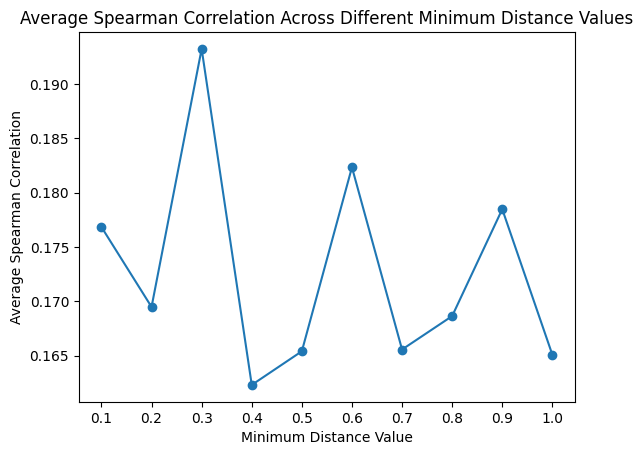

In [1]:
import matplotlib.pyplot as plt
import numpy as np

spearman_correlations_n15_1 = [0.1920, 0.1630, 0.1921, 0.1708, 0.1565, 0.1832, 0.1615, 0.1966, 0.1430, 0.1677]
spearman_correlations_n15_2 = [0.1559, 0.1714, 0.2035, 0.1615, 0.1575, 0.1399, 0.1449, 0.1707, 0.1924, 0.1702]
spearman_correlations_n15_3 = [0.1845, 0.1731, 0.2101, 0.1334, 0.1769, 0.1776, 0.1999, 0.1750, 0.1731, 0.1648]
spearman_correlations_n15_4 = [0.1795, 0.1465, 0.1898, 0.1844, 0.1589, 0.2447, 0.1557, 0.1527, 0.2140, 0.1664]
spearman_correlations_n15_5 = [0.1723, 0.1934, 0.1707, 0.1614, 0.1772, 0.1663, 0.1658, 0.1482, 0.1699, 0.1563]

all_lists = [
    spearman_correlations_n15_1,
    spearman_correlations_n15_2,
    spearman_correlations_n15_3,
    spearman_correlations_n15_4,
    spearman_correlations_n15_5,
]

# Calculate the average value for each index across all lists
index_averages = []
for i in range(len(spearman_correlations_n15_1)):
    index_values = [lst[i] for lst in all_lists]
    index_average = sum(index_values) / len(index_values)
    index_averages.append(index_average)

# Create a list of minimum distance values from 0.1 to 1.0 with intervals of 0.1
distance_values = np.arange(0.1, 1.1, 0.1)  # [0.1, 0.2, 0.3, ..., 0.9, 1.0]

# Plot the index averages in a line graph
plt.plot(distance_values, index_averages, marker='o')

# Add labels and title
plt.xlabel("Minimum Distance Value")
plt.ylabel("Average Spearman Correlation")
plt.title("Average Spearman Correlation Across Different Minimum Distance Values")

# Customize the x-axis ticks
plt.xticks(distance_values)

# Display the plot
plt.show()